In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, pearsonr
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def conjunct_vol_calc(V_s, V_r, D):
    # calculates the conjunct volume based on the segmentation volume, reference volume and dice overlap
    V_c = D * (V_s + V_r) / 2.0
    return V_c

In [4]:
# --- first load in and organise the data from the HCs ---
df_rows = []

hc_df = pd.read_csv("HC_stats.csv").set_index("Segmentation")
group = "HC"
updrs = None

for idx, row in hc_df.iterrows():

    if row["age"] != 0: # participants outside the age range already coded as 0 in the excel file

        lgn_l_vol = row["LGN-L"]
        lgn_r_vol = row["LGN-R"]
        mgn_l_vol = row["MGN-L"]
        mgn_r_vol = row["MGN-R"]
        age = row["age"]
        sex = row["sex"]

        # make 4 rows per subject
        df_rows.extend([
            {"subj_id": idx[:7], "group": group, "structure": "LGN",
             "hemisphere": "L", "volume_mm3": lgn_l_vol, "age": age,
             "sex": sex, "UPDRS": updrs},
    
            {"subj_id": idx[:7], "group": group, "structure": "LGN",
             "hemisphere": "R", "volume_mm3": lgn_r_vol, "age": age,
             "sex": sex, "UPDRS": updrs},
    
            {"subj_id": idx[:7], "group": group, "structure": "MGN",
             "hemisphere": "L", "volume_mm3": mgn_l_vol, "age": age,
             "sex": sex, "UPDRS": updrs},
    
            {"subj_id": idx[:7], "group": group, "structure": "MGN",
             "hemisphere": "R", "volume_mm3": mgn_r_vol, "age": age,
             "sex": sex, "UPDRS": updrs},
        ])

df1 = pd.DataFrame(df_rows)


# --- now load in and organise the data from the PD group ---
df_rows = []

pd_df = pd.read_csv("PD_stats.csv").set_index("id")
group = "PD"

for idx, row in pd_df.iterrows():

    # Left LGN
    lgn_l_vol = conjunct_vol_calc(row["V-s_lgn-l"], row["V-r_lgn-l"], row["Dice_lgn-l"])
    # Right LGN
    lgn_r_vol = conjunct_vol_calc(row["V-s_lgn-r"], row["V-r_lgn-r"], row["Dice_lgn-r"])

    # Left MGN
    mgn_l_vol = conjunct_vol_calc(row["V-s_mgn-l"], row["V-r_mgn-l"], row["Dice_mgn-l"])
    # Right MGN
    mgn_r_vol = conjunct_vol_calc(row["V-s_mgn-r"], row["V-r_mgn-r"], row["Dice_mgn-r"])

    age = row["age"]
    sex = row["sex"]
    updrs = row["UPDRS"]

    # build 4 rows per subject
    df_rows.extend([
        {"subj_id": idx, "group": group, "structure": "LGN",
         "hemisphere": "L", "volume_mm3": lgn_l_vol, "age": age,
         "sex": sex, "UPDRS": updrs},

        {"subj_id": idx, "group": group, "structure": "LGN",
         "hemisphere": "R", "volume_mm3": lgn_r_vol, "age": age,
         "sex": sex, "UPDRS": updrs},

        {"subj_id": idx, "group": group, "structure": "MGN",
         "hemisphere": "L", "volume_mm3": mgn_l_vol, "age": age,
         "sex": sex, "UPDRS": updrs},

        {"subj_id": idx, "group": group, "structure": "MGN",
         "hemisphere": "R", "volume_mm3": mgn_r_vol, "age": age,
         "sex": sex, "UPDRS": updrs},
    ])

df2 = pd.DataFrame(df_rows)

# combine both into one dataframe
df = pd.concat([df1, df2], ignore_index=True)
df.to_csv("data.csv") 

C:\Users\Aiden\AppData\Local\Temp\ipykernel_13692\2784044502.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df1, df2], ignore_index=True)


In [5]:
df = df.copy()

# --- log-transform volume  ---
skewness = df["volume_mm3"].skew()
if abs(skewness) > 1.0:
    df["volume"] = np.log(df["volume_mm3"])
else:
    df["volume"] = df["volume_mm3"]

# --- standardise continuous variables ---
def zscore(x):
    return (x - x.mean()) / x.std()

df["z_volume"] = zscore(df["volume"])
df["z_age"] = zscore(df["age"])

# UPDRS only standardised within PD group
df["z_UPDRS"] = df.groupby("group")["UPDRS"].transform(lambda x: zscore(x) if x.notnull().any() else x)

# --- effect coding for categorical predictors ---
# Group: HC=0, PD=1
df["group_code"] = df["group"].map({"HC": 0, "PD": 1})

# Hemisphere: Left(L)=-0.5, Right(R)=0.5
df["hemi_code"] = df["hemisphere"].map({"L": -0.5, "R": 0.5})

# Structure: LGN=-0.5, MGN=0.5
df["struct_code"] = df["structure"].map({"LGN": -0.5, "MGN": 0.5})

# Sex: male(m)=0, female(f)=1
df["sex_code"] = df["sex"].map({"m": 0, "f": 1})

# --- label outliers ---
z = (df["z_volume"] - df["z_volume"].mean())/df["z_volume"].std()
df["outlier"] = (z.abs() > 3)

n_outliers = df["outlier"].sum()
print(f"Number of outliers: {n_outliers}")


Number of outliers: 0


In [6]:
with pm.Model() as model:

    # Data
    X_group = df["group_code"].values
    X_struct = df["struct_code"].values
    X_hemi = df["hemi_code"].values
    X_age = df["z_age"].values
    X_sex = df["sex_code"].values
    subj_idx = df["subj_id"].astype('category').cat.codes.values

    # Priors
    intercept = pm.Normal("Intercept", mu=0, sigma=1)
    beta_group = pm.Normal("beta_group", mu=0, sigma=1)
    beta_struct = pm.Normal("beta_struct", mu=0, sigma=1)
    beta_hemi = pm.Normal("beta_hemi", mu=0, sigma=1)
    beta_gs = pm.Normal("beta_gs", mu=0, sigma=1)
    beta_gh = pm.Normal("beta_gh", mu=0, sigma=1)
    beta_sh = pm.Normal("beta_sh", mu=0, sigma=1)
    beta_gsh = pm.Normal("beta_gsh", mu=0, sigma=1)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1)
    beta_sex = pm.Normal("beta_sex", mu=0, sigma=1)

    # Random intercepts
    sigma_subject = pm.HalfStudentT("sigma_subject", nu=3, sigma=1)
    n_subj = df["subj_id"].nunique()

    subject_offset = pm.Normal("subject_offset", mu=0, sigma=1, shape=n_subj)
    subject_effect = subject_offset * sigma_subject

    # Linear predictor
    mu = (
        intercept
        + beta_group * X_group
        + beta_struct * X_struct
        + beta_hemi * X_hemi
        + beta_gs * (X_group * X_struct)
        + beta_gh * (X_group * X_hemi)
        + beta_sh * (X_struct * X_hemi)
        + beta_gsh * (X_group * X_struct * X_hemi)
        + beta_age * X_age
        + beta_sex * X_sex
        + subject_effect[subj_idx]
    )


    # Student-t likelihood
    nu = pm.Exponential("nu_minus1", 1 / 30.) + 1.
    sigma = pm.HalfStudentT("sigma", nu=3, sigma=1)

    y = pm.StudentT(
        "y",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=df['z_volume'].values,
    )

    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        random_seed=14933268,
        return_inferencedata=True,
        nuts_sampler_kwargs={
            "target_accept": 0.95,
            "max_treedepth": 15
    }
    )
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["y"], random_seed=14933268)

C:\Users\Aiden\anaconda3\envs\pymc_env\lib\site-packages\pymc\model.py:1402: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_group, beta_struct, beta_hemi, beta_gs, beta_gh, beta_sh, beta_gsh, beta_age, beta_sex, sigma_subject, subject_offset, nu_minus1, sigma, y_missing]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 70 seconds.
Sampling: [y_observed]


In [7]:
# Summary of all posterior parameters
summary_df = az.summary(trace, hdi_prob=0.95) 

# Export to CSV
summary_df.to_csv("posterior_summary_main.csv", index=True) 

C:\Users\Aiden\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Aiden\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
C:\Users\Aiden\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Aiden\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
C:\Users\Aiden\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within

In [7]:
posterior = trace.posterior

def posterior_prob(samples, less=True):
    if less:
        return float(np.mean(samples < 0))
    else:
        return float(np.mean(samples > 0))

probabilities = {
    "beta_group_P(β<0)": posterior_prob(posterior["beta_group"], less=True),
    "beta_struct_P(β<0)": posterior_prob(posterior["beta_struct"], less=True),
    "beta_hemi_P(β<0)": posterior_prob(posterior["beta_hemi"], less=True),
    "beta_age_P(β<0)": posterior_prob(posterior["beta_age"], less=True),
    "beta_sex_P(β<0)": posterior_prob(posterior["beta_sex"], less=True),

    # Interactions
    "beta_gs_P(β>0)": posterior_prob(posterior["beta_gs"], less=False),
    "beta_gh_P(β>0)": posterior_prob(posterior["beta_gh"], less=False),
    "beta_sh_P(β>0)": posterior_prob(posterior["beta_sh"], less=False),
    "beta_gsh_P(β<0)": posterior_prob(posterior["beta_gsh"], less=True)
}

posterior_probs_df = pd.DataFrame.from_dict(
    probabilities, orient='index', columns=["Posterior Probability"]
)

print(posterior_probs_df)


                    Posterior Probability
beta_group_P(β<0)                0.886625
beta_struct_P(β<0)               1.000000
beta_hemi_P(β<0)                 0.944125
beta_age_P(β<0)                  0.985125
beta_sex_P(β<0)                  0.993875
beta_gs_P(β>0)                   0.993875
beta_gh_P(β>0)                   0.998875
beta_sh_P(β>0)                   1.000000
beta_gsh_P(β<0)                  1.000000


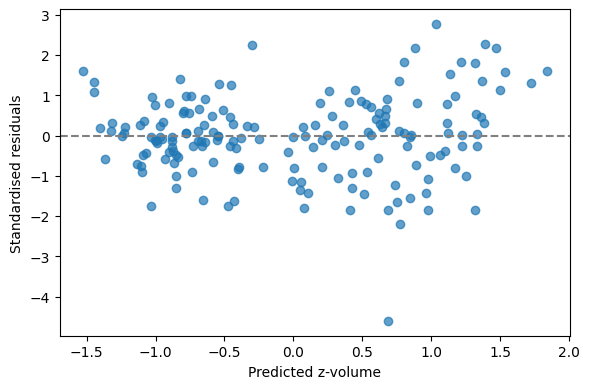

In [9]:
# --- inspecting the residuals ---
y_pred_samples = posterior_pred.posterior_predictive["y"].values
n_chains, n_draws, n_obs = y_pred_samples.shape
y_pred_flat = y_pred_samples.reshape((n_chains * n_draws, n_obs))

# compute posterior predictive mean for each observation
y_pred_mean = y_pred_flat.mean(axis=0)

# compute standardised residuals
y_obs = df["z_volume"].values
residuals = y_obs - y_pred_mean
std_residuals = residuals / np.nanstd(residuals)

# plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_mean, std_residuals, alpha=0.7)
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Predicted z-volume")
plt.ylabel("Standardised residuals")
plt.tight_layout()
plt.show()

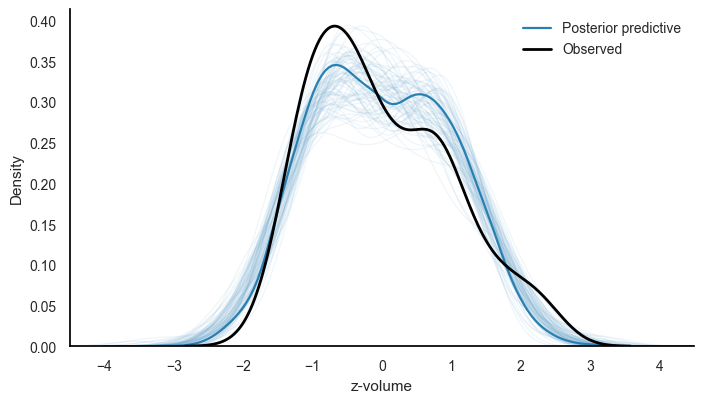

In [10]:
# --- posterior predictive check ---

# load observed y
if ("observed_data" in posterior_pred.groups()) and ("y" in posterior_pred.observed_data):
    y_obs = posterior_pred.observed_data["y"].values
else:
    y_obs = df["z_volume"].values

# extract posterior predictive samples
y_pp = posterior_pred.posterior_predictive["y"].values
n_chains, n_draws, n_obs = y_pp.shape
y_pp_flat = y_pp.reshape((n_chains * n_draws, n_obs))

# choose draws to plot
rng = np.random.default_rng(14933268)
n_plot = min(80, y_pp_flat.shape[0])  # cap at 80 lines
chosen = rng.choice(y_pp_flat.shape[0], size=n_plot, replace=False)

# plot
sns.set(style="white", rc={"axes.edgecolor": "black"})

plt.figure(figsize=(7.2, 4.2))
ax = plt.gca()

# light predictive densities
for idx in chosen:
    sns.kdeplot(y_pp_flat[idx, :], ax=ax, color="#7fb3d5", alpha=0.12, linewidth=0.9)

# thick predictive median density
sns.kdeplot(y_pp_flat[chosen, :].ravel(), ax=ax, color="#2a7fb2", linewidth=1.6, label="Posterior predictive")

# observed density
sns.kdeplot(y_obs, ax=ax, color="black", linewidth=2.0, label="Observed")

ax.set_xlabel("z-volume", fontsize=11)
ax.set_ylabel("Density", fontsize=11)
ax.tick_params(axis="both", labelsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlim(-4.5, 4.5)

ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show()

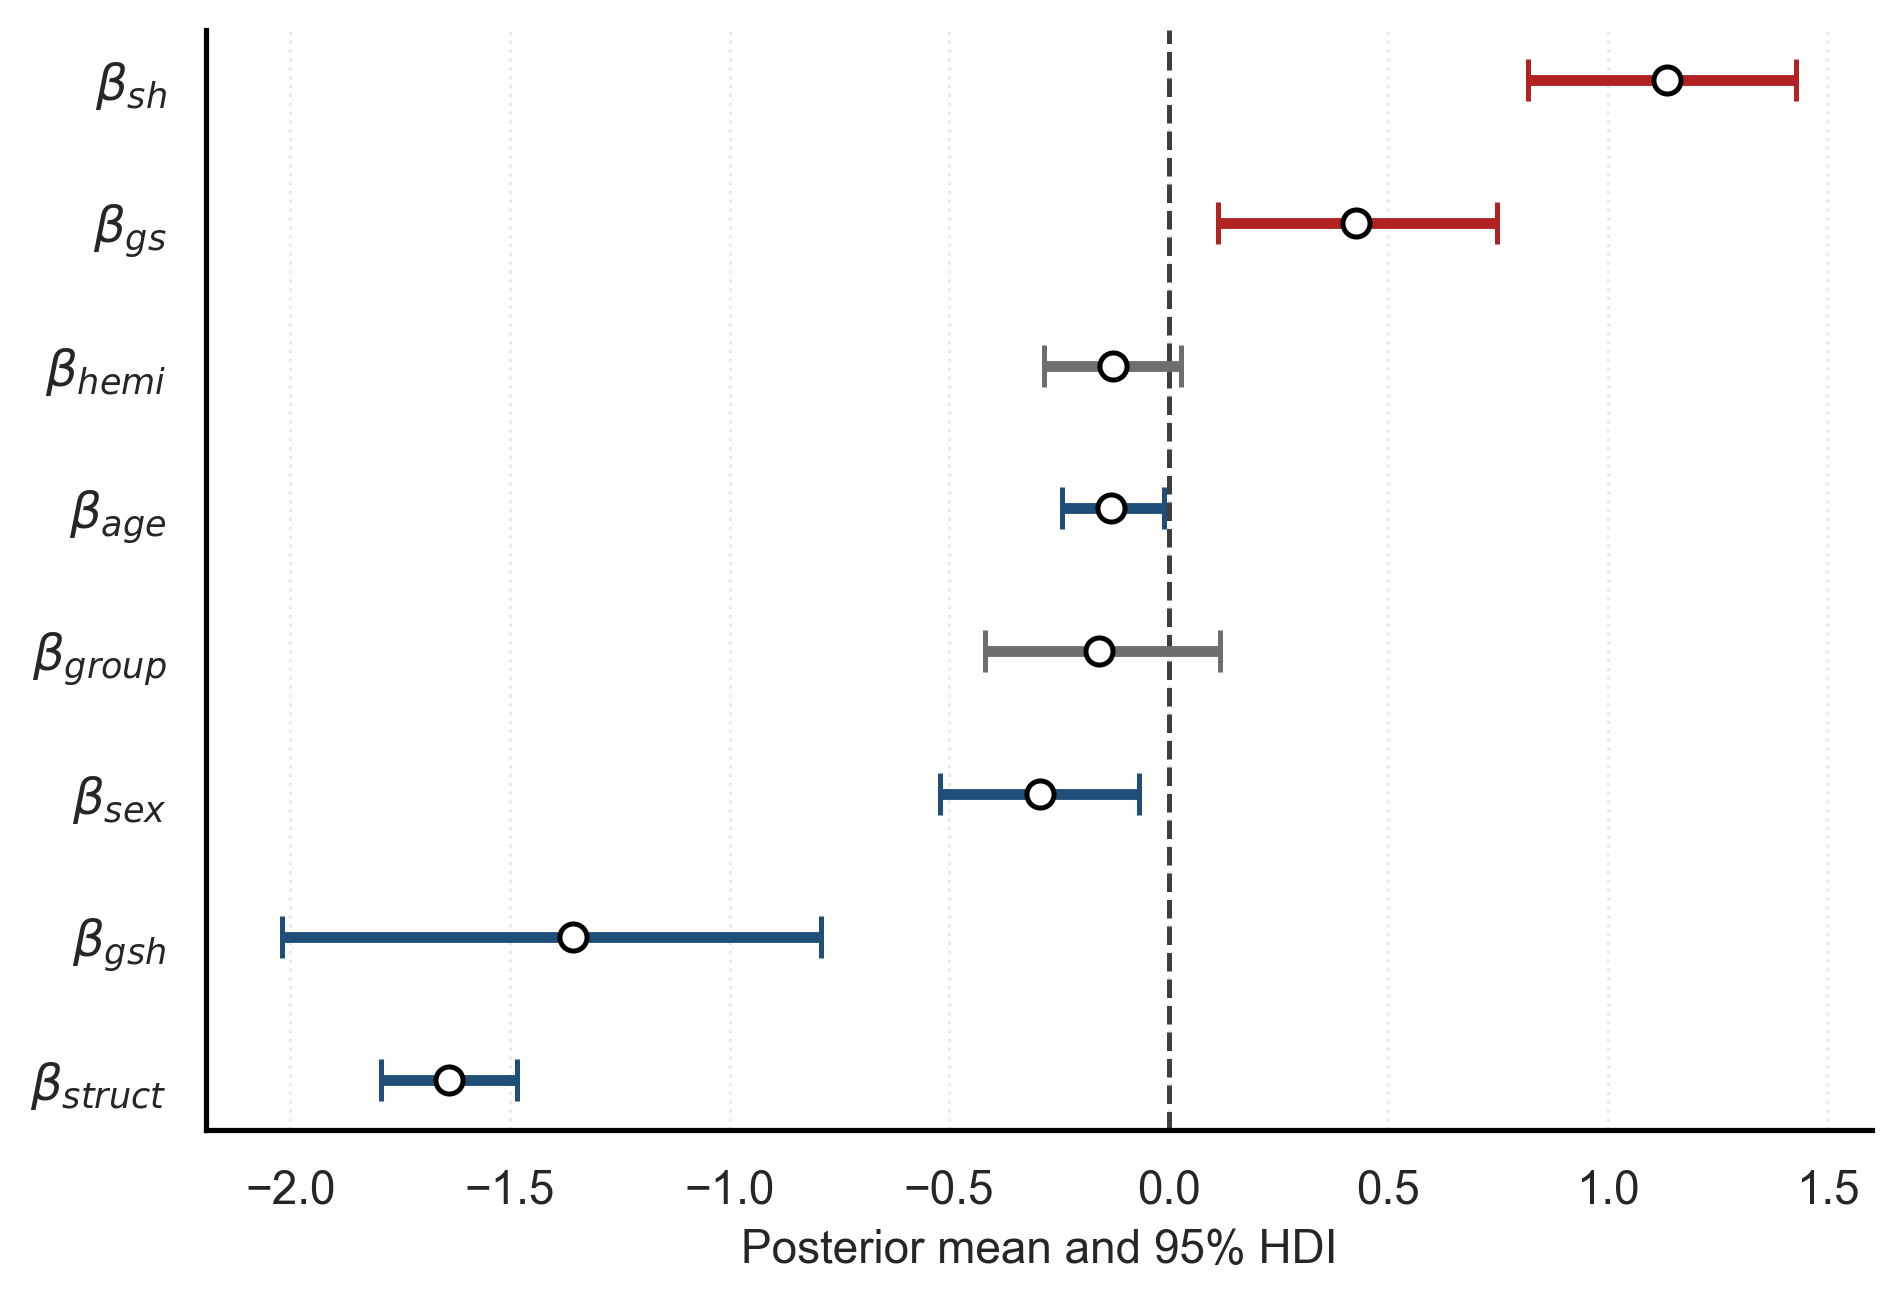

In [13]:
def forest_plotter(param_names, model, sort=True, figsize=(6.5, 4.5), hdi_prob=0.95, dpi=300):
    # extract posterior
    post = model.posterior[param_names]
    means = post.mean(dim=("chain", "draw")).to_array().values
    hdi = az.hdi(post, hdi_prob=hdi_prob).to_array().values
    lower, upper = hdi[:, 0], hdi[:, 1]

    if sort:
        idx = np.argsort(means)
        means, lower, upper = means[idx], lower[idx], upper[idx]
        param_names = [param_names[i] for i in idx]

    labels = [r"$\beta_{" + p.replace("beta_", "") + r"}$" for p in param_names]
    y = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    COLOUR_POS = "#B22222"   # muted red
    COLOUR_NEG = "#1F4E79"   # muted blue
    COLOUR_NEU = "#6E6E6E"   # neutral gray

    def choose_colour(l, u):
        if u < 0:
            return COLOUR_NEG
        elif l > 0:
            return COLOUR_POS
        else:
            return COLOUR_NEU

    colours = [choose_colour(l, u) for l, u in zip(lower, upper)]

    # HDI bars with whiskers
    for yi, m, l, u, c in zip(y, means, lower, upper, colours):
        ax.errorbar(m, yi, xerr=[[m - l], [u - m]], fmt="o", color=c, ecolor=c, elinewidth=2.6, capsize=5, capthick=2.6, markersize=6.5,
                    markerfacecolor="white", markeredgecolor="black", markeredgewidth=1.2, zorder=3)

    # zero reference line
    ax.axvline(0, linestyle="--", linewidth=1.2, color="black", alpha=0.75, zorder=1)

    # axes & labels
    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=12)
    ax.set_xlabel(f"Posterior mean and {int(hdi_prob*100)}% HDI", fontsize=11)
    ax.tick_params(axis="x", labelsize=11)

    # light grid for alignment
    ax.grid(axis="x", linestyle=":", linewidth=0.8, alpha=0.4)

    # clean spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    plt.tight_layout()
    return fig, ax

param_names_main = ["beta_sex", "beta_age","beta_gsh", "beta_sh", "beta_gs", "beta_hemi", "beta_struct", "beta_group"]
fig, ax = forest_plotter(param_names_main, trace)

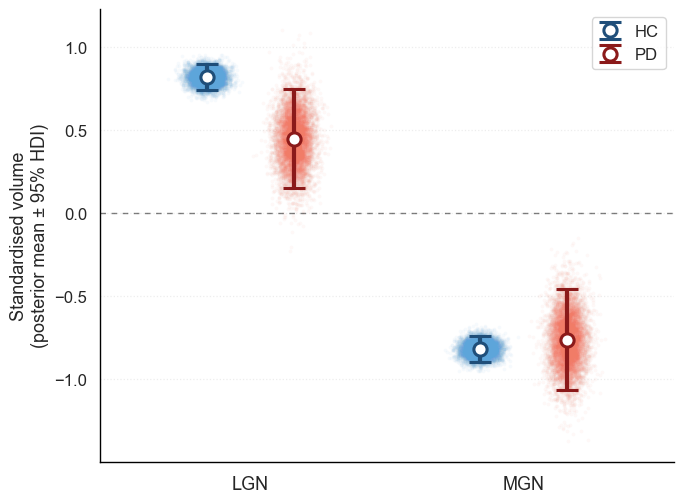

In [14]:
# posterior samples
g = posterior["beta_group"]
s = posterior["beta_struct"]
gs = posterior["beta_gs"]

# effect coding
structure_vals = {"LGN": -0.5, "MGN": 0.5}
groups = {"HC": 0, "PD": 1}

# compute posterior distributions for each group × structure combination
posterior_values = {}
for struct_name, S in structure_vals.items():
    for group_name, G in groups.items():
        samples = g * G + s * S + gs * G * S
        posterior_values[(group_name, struct_name)] = samples

# compute means and HDIs
summary = {}
for key, samples in posterior_values.items():
    mean = np.mean(samples)
    hdi_low, hdi_high = np.percentile(samples, [2.5, 97.5])
    summary[key] = {"mean": mean, "hdi": (hdi_low, hdi_high)}

fig, ax = plt.subplots(figsize=(7, 5.2))

# --------layout parameters-------------
x = np.arange(len(structure_vals))
xticks = list(structure_vals.keys())

offset = 0.16
jitter = 0.035
hc_sample_colour = "#5DA5DA"   # desaturated blue
pd_sample_colour = "#F17C67"   # desaturated red
hc_colour = "#1F4E79"          # deep blue
pd_colour = "#8B1A1A"          # deep red

#-------------posterior samples-------------
for i, struct in enumerate(xticks):
    hc_samples = np.ravel(posterior_values[("HC", struct)])
    ax.scatter(np.random.normal(x[i] - offset, jitter, size=hc_samples.size), hc_samples, color=hc_sample_colour, alpha=0.05, s=7, linewidths=0, zorder=1)

    pd_samples = np.ravel(posterior_values[("PD", struct)])
    ax.scatter(np.random.normal(x[i] + offset, jitter, size=pd_samples.size), pd_samples, color=pd_sample_colour, alpha=0.05, s=7, linewidths=0, zorder=1)

#-------------posterior summaries-------------
hc_means = [summary[("HC", s)]["mean"] for s in xticks]
pd_means = [summary[("PD", s)]["mean"] for s in xticks]

hc_err = [[summary[("HC", s)]["mean"] - summary[("HC", s)]["hdi"][0] for s in xticks],
          [summary[("HC", s)]["hdi"][1] - summary[("HC", s)]["mean"] for s in xticks]]
pd_err = [[summary[("PD", s)]["mean"] - summary[("PD", s)]["hdi"][0] for s in xticks],
          [summary[("PD", s)]["hdi"][1] - summary[("PD", s)]["mean"] for s in xticks]]

ax.errorbar(x - offset, hc_means, yerr=hc_err, fmt="o", color=hc_colour, ecolor=hc_colour, capsize=8, markersize=9.5, linewidth=3,
            markerfacecolor="white", markeredgewidth=2.2, label="HC", zorder=4)

ax.errorbar(x + offset, pd_means, yerr=pd_err, fmt="o", color=pd_colour, ecolor=pd_colour, capsize=8, markersize=9.5, linewidth=3, 
            markerfacecolor="white", markeredgewidth=2.2, label="PD", zorder=4)

#-------------reference & axes styling-------------
ax.axhline(0, color="black", linestyle=(0, (4, 4)), linewidth=1, alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(xticks, fontsize=13)
ax.set_ylabel("Standardised volume\n(posterior mean ± 95% HDI)", fontsize=13)

ax.tick_params(axis="y", labelsize=12)
ax.set_xlim(-0.55, len(x) - 0.45)

# light grid for alignment
ax.grid(axis="y", linestyle=':', linewidth=0.9, alpha=0.35)
ax.set_axisbelow(True)

# spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# legend
ax.legend(frameon=True, fontsize=12, handlelength=1.4, loc="upper right")
plt.tight_layout()
plt.show()


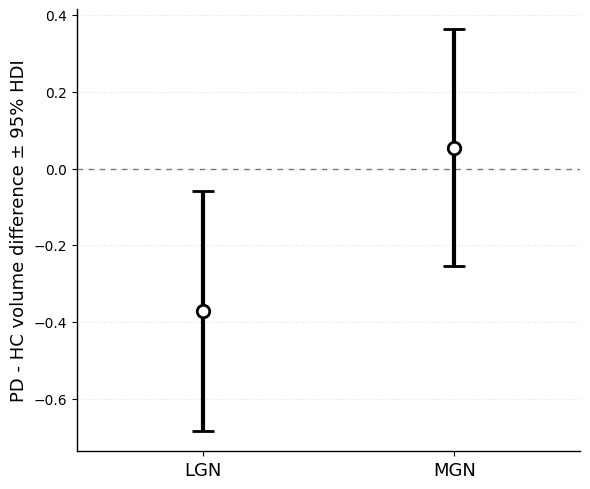

LGN: ΔPD-HC = -0.37, 95% HDI = [-0.69, -0.06]
MGN: ΔPD-HC = 0.05, 95% HDI = [-0.25, 0.36]


In [15]:
# ---- posterior samples ----
g = posterior["beta_group"]
s = posterior["beta_struct"]
gs = posterior["beta_gs"]

# effect coding
structure_vals = {"LGN": -0.5, "MGN": 0.5}

# ---- compute PD-HC posterior for each structure ----
delta_posterior = {}
for struct_name, S in structure_vals.items():
    delta_samples = g * (1 - 0) + gs * (1 - 0) * S  # PD-HC = g + gs*S
    delta_posterior[struct_name] = delta_samples

# ---- compute means and HDIs ----
summary = {}
for struct, samples in delta_posterior.items():
    mean = np.mean(samples)
    hdi_low, hdi_high = np.percentile(samples, [2.5, 97.5])
    summary[struct] = {"mean": mean, "hdi": (hdi_low, hdi_high)}

# ---- plotting ----
fig, ax = plt.subplots(figsize=(6, 5))

x = np.arange(len(structure_vals))
xticks = list(structure_vals.keys())
delta_means = [summary[s]["mean"] for s in xticks]
delta_err = [[summary[s]["mean"] - summary[s]["hdi"][0] for s in xticks],
             [summary[s]["hdi"][1] - summary[s]["mean"] for s in xticks]]
'''
# scatter posterior samples lightly
for i, struct in enumerate(xticks):
    ax.scatter(np.random.normal(x[i], 0.02, size=delta_posterior[struct].size),
               delta_posterior[struct], color="#F17C67", alpha=0.05, s=7)
'''
# plot mean ± 95% HDI
ax.errorbar(x, delta_means, yerr=delta_err, fmt="o", color="black",
            ecolor="black", capsize=8, markersize=9, linewidth=3,
            markerfacecolor="white", markeredgewidth=2)

# reference line at 0
ax.axhline(0, color="black", linestyle=(0, (4, 4)), linewidth=1, alpha=0.5)

# axes & labels
ax.set_xticks(x)
ax.set_xticklabels(xticks, fontsize=13)
ax.set_ylabel("PD - HC volume difference ± 95% HDI", fontsize=13)
ax.set_xlim(-0.5, len(x)-0.5)
ax.grid(axis="y", linestyle=':', linewidth=0.9, alpha=0.35)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

plt.tight_layout()
plt.show()

for struct, stats in summary.items():
    print(f"{struct}: ΔPD-HC = {stats['mean']:.2f}, 95% HDI = [{stats['hdi'][0]:.2f}, {stats['hdi'][1]:.2f}]")

